# Source file for Network Science (21/22) project "Knowledge graphs from four e-books"
## Author: Steven Leego

# 1. Data preparation

In [8]:
file_a = open("11-0.txt", 'rb').read()
file_a = file_a.decode('utf-8')

In [9]:
file_a[0:100]

'\ufeffThe Project Gutenberg eBook of Alice’s Adventures in Wonderland, by Lewis Carroll\r\n\r\nThis eBook is '

In [10]:
file_f = open("84-0.txt", 'rb').read()
file_f = file_f.decode('utf-8')

In [11]:
file_f[0:100]

'\ufeffThe Project Gutenberg eBook of Frankenstein, by Mary Wollstonecraft (Godwin) Shelley\r\n\r\nThis eBook '

In [2]:
file_t = open("74-0.txt", 'rb').read()
file_t = file_t.decode('utf-8')
file_t[0:100]

'\ufeffThe Project Gutenberg eBook of The Adventures of Tom Sawyer, by Mark Twain\r\n\r\nThis eBook is for the'

In [4]:
file_j = open("43-0.txt", 'rb').read()
file_j = file_j.decode('utf-8')
file_j[0:100]

'\ufeffThe Project Gutenberg eBook of The Strange Case Of Dr. Jekyll And Mr. Hyde, by Robert Louis Stevens'

In [5]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [12]:
docs = []
docs.append(nlp(file_a))
docs.append(nlp(file_t))
docs.append(nlp(file_f))
docs.append(nlp(file_j))

In [13]:
docs[0][0:100]

﻿The Project Gutenberg eBook of Alice’s Adventures in Wonderland, by Lewis Carroll

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country

In [15]:
sentences = []
for doc in docs:
    sentences.append([sent.text for sent in doc.sents])

In [16]:
sentences[0][0:2]

['\ufeffThe Project Gutenberg eBook of Alice’s Adventures in Wonderland, by Lewis Carroll\r\n\r\nThis eBook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever.',
 'You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg License included with this eBook or online at\r\nwww.gutenberg.org.']

In [18]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  if (ent1.strip() != '') and (ent2.strip() != ''):
        return sent, [ent1.strip(), ent2.strip()]

In [19]:
get_entities(sentences[0][1])

('You may copy it, give it away or re-use it under the terms\r\nof the Project Gutenberg License included with this eBook or online at\r\nwww.gutenberg.org.',
 ['away Gutenberg License', 'www.gutenberg.org'])

In [20]:
entity_pairs_all = []
valid_sentences_all = []

for sentence in sentences:
    entity_pairs = []
    valid_sentences = []
    for i in tqdm(sentence):
        result = get_entities(i)
        if result:
            valid_sentences.append(result[0])
            entity_pairs.append(result[1])
    entity_pairs_all.append(entity_pairs)
    valid_sentences_all.append(valid_sentences)
        

100%|██████████| 1347/1347 [00:05<00:00, 264.58it/s]


In [21]:
for entity_pairs in entity_pairs_all:
    print(len(entity_pairs))

1157
3418
3033
1049


In [23]:
entity_pairs_all[0][10:20]

[['how  she', 'how  world'],
 ['herself', 'herself'],
 ['what', 'her'],
 ['maps', 'pegs'],
 ['so  she', 'it'],
 ['I', 'stairs'],
 ['all  me', 'home'],
 ['even  I', 'house'],
 ['never  _', 'end'],
 ['miles  I', 'time']]

In [24]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [[{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}]]

  matcher.add("matching_1", pattern) 

  matches = matcher(doc)
  if(matches):
      k = len(matches) - 1
      span = doc[matches[k][1]:matches[k][2]] 

      return(span.text)

In [25]:
relations = []
for valid_sentences in valid_sentences_all:    
    relations.append([get_relation(i) for i in tqdm(valid_sentences)])

100%|██████████| 1049/1049 [00:04<00:00, 232.85it/s]


In [26]:
relations[0][0:20]

['is for',
 'copy',
 'have',
 'encoding',
 '’S',
 'CHAPTER',
 'thought',
 'considering in',
 'was',
 None,
 'went',
 'went',
 'was',
 'tried',
 'labelled',
 'thought',
 'think',
 'say',
 'come to',
 'wonder']

In [36]:
kg_dfs = []
Gs = []

for j in range(4):
    

    # extract subject
    source = [i[0] for i in entity_pairs_all[j]]

    # extract object
    target = [i[1] for i in entity_pairs_all[j]]
    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations[j]})
    #dropping invalid values
    kg_df = kg_df.dropna()
    kg_dfs.append(kg_df)
    Gs.append(nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph()))

In [ ]:
kg_dfs[0]['edge'].describe()

count     1063
unique     375
top       said
freq       252
Name: edge, dtype: object

# 2. Data Analysis

## 2.1 General analysis

In [43]:
import numpy as np
def net_prop_dict(G):
    prop_dict = {}

    prop_dict['no_of_nodes'] = nx.number_of_nodes(G)
    prop_dict['no_of_edges'] = nx.number_of_edges(G)  
    prop_dict['edge_density'] = nx.classes.function.density(G)
    prop_dict['average_degree'] = np.array([d for n, d in G.degree()]).sum()/nx.number_of_nodes(G)
    return prop_dict

Alice: {'no_of_nodes': 1231, 'no_of_edges': 1063, 'edge_density': 0.0007020533243512776, 'average_degree': 1.7270511779041429} 

 Degree distribution:


(array([1.214e+03, 1.000e+01, 3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  12.4,  23.8,  35.2,  46.6,  58. ,  69.4,  80.8,  92.2,
        103.6, 115. ]),
 <BarContainer object of 10 artists>)

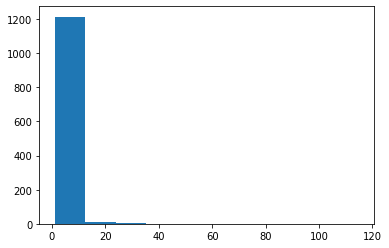

In [55]:
print("Alice:", net_prop_dict(Gs[0]),"\n\n","Degree distribution:")
degrees = [Gs[0].degree(n) for n in Gs[0].nodes()]
plt.hist(degrees)

Tom Sawyer: {'no_of_nodes': 3478, 'no_of_edges': 3129, 'edge_density': 0.0002587445999778715, 'average_degree': 1.7993099482461186} 

 Degree distribution:


(array([3.463e+03, 6.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  1.,  31.,  61.,  91., 121., 151., 181., 211., 241., 271., 301.]),
 <BarContainer object of 10 artists>)

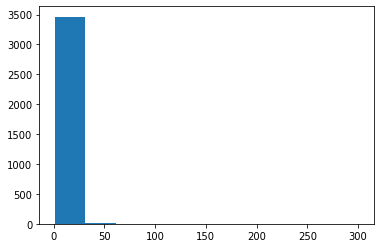

In [56]:
print("Tom Sawyer:", net_prop_dict(Gs[1]),"\n\n","Degree distribution:")
degrees = [Gs[1].degree(n) for n in Gs[1].nodes()]
plt.hist(degrees)

Frankenstein: {'no_of_nodes': 3356, 'no_of_edges': 2732, 'edge_density': 0.00024264213482447523, 'average_degree': 1.628128724672229} 

 Degree distribution:


(array([3.349e+03, 4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  46.9,  92.8, 138.7, 184.6, 230.5, 276.4, 322.3, 368.2,
        414.1, 460. ]),
 <BarContainer object of 10 artists>)

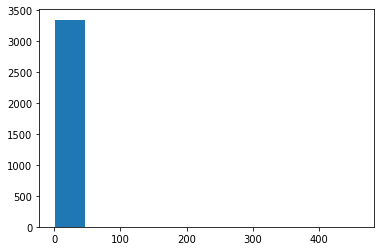

In [57]:
print("Frankenstein:", net_prop_dict(Gs[2]),"\n\n","Degree distribution:")
degrees = [Gs[2].degree(n) for n in Gs[2].nodes()]
plt.hist(degrees)

Jekyll and Hyde: {'no_of_nodes': 1266, 'no_of_edges': 946, 'edge_density': 0.0005906999107081531, 'average_degree': 1.4944707740916272} 

 Degree distribution:


(array([1.252e+03, 7.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. ,  9.7, 18.4, 27.1, 35.8, 44.5, 53.2, 61.9, 70.6, 79.3, 88. ]),
 <BarContainer object of 10 artists>)

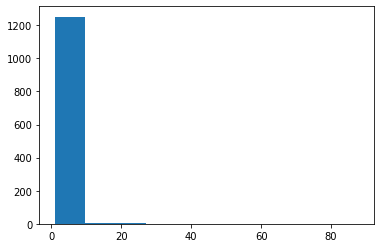

In [58]:
print("Jekyll and Hyde:", net_prop_dict(Gs[3]),"\n\n","Degree distribution:")
degrees = [Gs[3].degree(n) for n in Gs[3].nodes()]
plt.hist(degrees)

## 2.2 Alice in the wonderland

In [65]:
pd.Series(kg_dfs[0]['edge']).value_counts()[:25]

said         252
was           39
thought       30
said to       25
went          16
is            16
began         13
cried         12
replied       12
’s            11
had           11
think         11
are           10
wonder         9
added          9
looked         9
know           9
have           9
were           7
took           7
tried          6
wish           6
gave           6
suppose        6
looked at      6
Name: edge, dtype: int64

In [62]:
pd.Series(kg_dfs[0]['source']).value_counts()[:25]

I              69
you            64
it             57
Alice          41
she            35
they           20
King           16
who            16
he             15
that           14
Gryphon        12
_              12
Queen          10
Hatter          9
You             9
March Hare      8
Mouse           8
so  she         7
we              7
Mock Turtle     6
Duchess         5
Cat             5
one             5
how  she        4
when  I         4
Name: source, dtype: int64

In [63]:
pd.Series(kg_dfs[0]['target']).value_counts()[:25]

it           58
_            17
herself      17
them         15
that         15
you          15
Alice        14
what         14
me           11
her          10
day           6
head          6
him           5
time          5
something     4
minute        4
Gryphon       4
King          4
dance         4
pardon        4
Dormouse      4
things        4
one           4
nonsense      3
Hatter        3
Name: target, dtype: int64

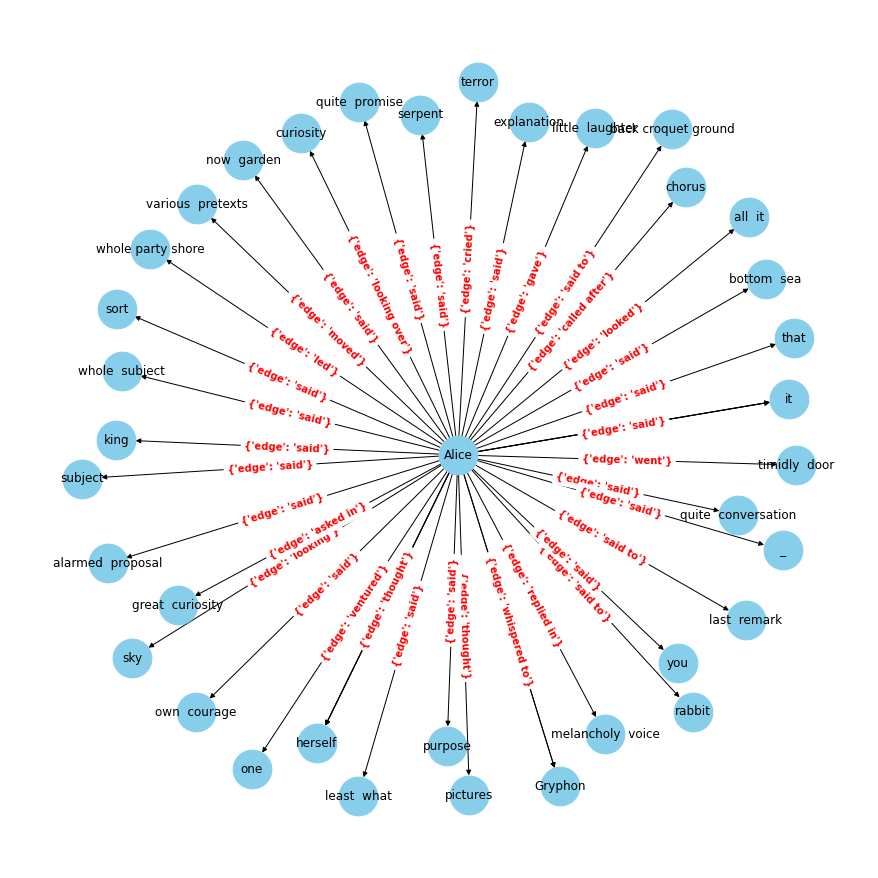

In [67]:
G=nx.from_pandas_edgelist(kg_dfs[0][kg_dfs[0]['source']=="Alice"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, pos, 
                             font_color='red', font_size=10, font_weight='bold')
plt.show()

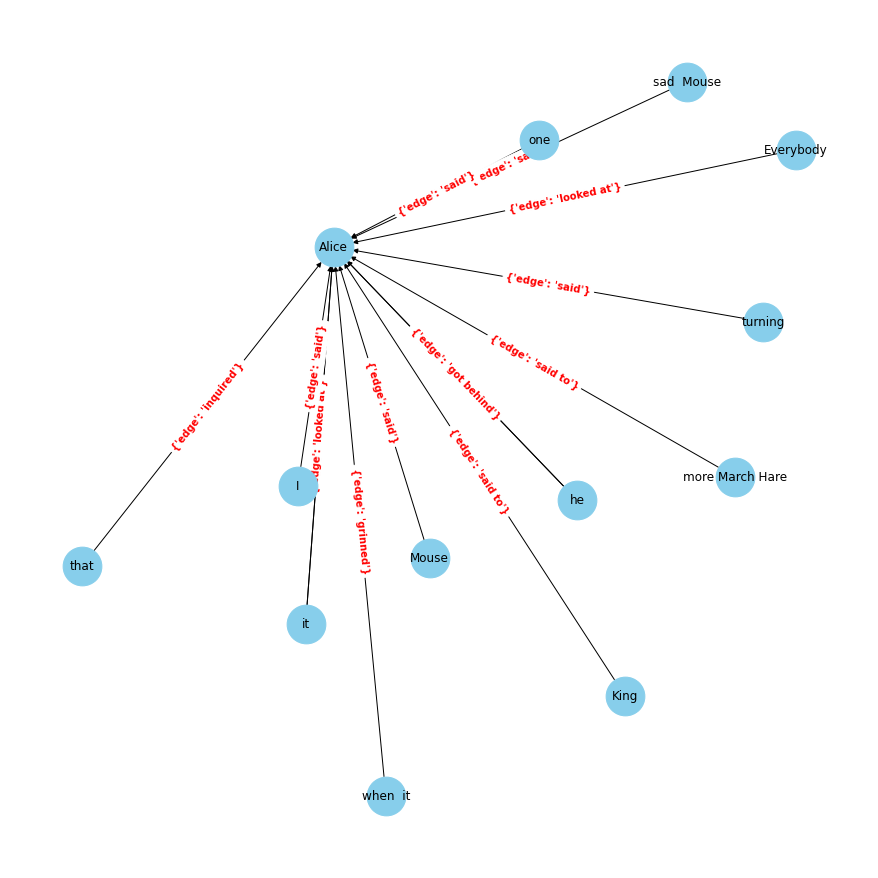

In [68]:
G=nx.from_pandas_edgelist(kg_dfs[0][kg_dfs[0]['target']=="Alice"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, pos, 
                             font_color='red', font_size=10, font_weight='bold')
plt.show()

## 2.3 Tom Sawyer

In [70]:
pd.Series(kg_dfs[1]['edge']).value_counts()[:25]

was        171
said       151
got         53
began       40
took        40
had         39
’s          38
know        36
do          35
reckon      33
came        32
is          30
were        29
found       28
see         27
tell        26
want        26
made        24
say         23
went        21
take        19
going       18
turned      17
let         16
thought     16
Name: edge, dtype: int64

In [71]:
pd.Series(kg_dfs[1]['source']).value_counts()[:25]

I             217
he            125
you           115
He             82
it             79
they           78
Tom            70
that           63
she            52
They           47
It             39
You            27
She            27
we             25
Huck           23
_              21
We             16
me             12
boys           12
So  he         11
Aunt Polly     11
Now  you       10
now  he        10
so  he          9
him             9
Name: source, dtype: int64

In [72]:
pd.Series(kg_dfs[1]['target']).value_counts()[:25]

it           222
him           92
you           69
that          58
me            38
_             36
them          34
what          23
What          22
us            21
anything      18
her           14
something     13
n’t           12
’em           11
moment        11
this          11
Tom           10
time           9
cave           9
face           9
mind           9
way            8
nothing        8
head           8
Name: target, dtype: int64

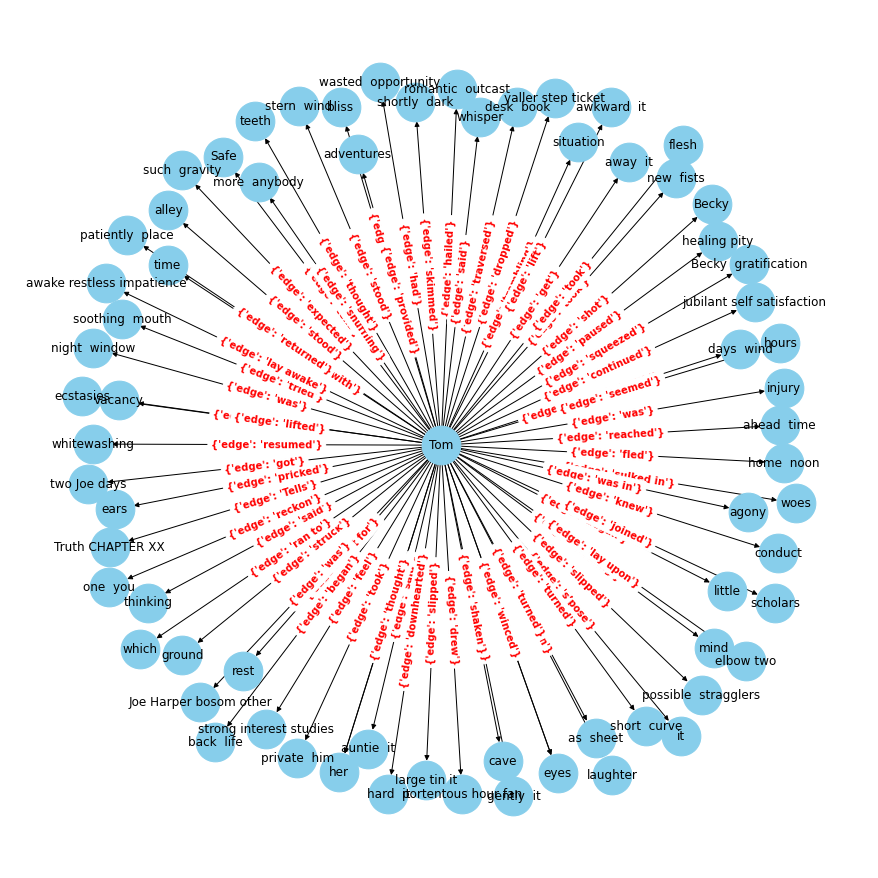

In [96]:
G=nx.from_pandas_edgelist(kg_dfs[1][kg_dfs[1]['source']=="Tom"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, pos, 
                             font_color='red', font_size=10, font_weight='bold')
plt.show()

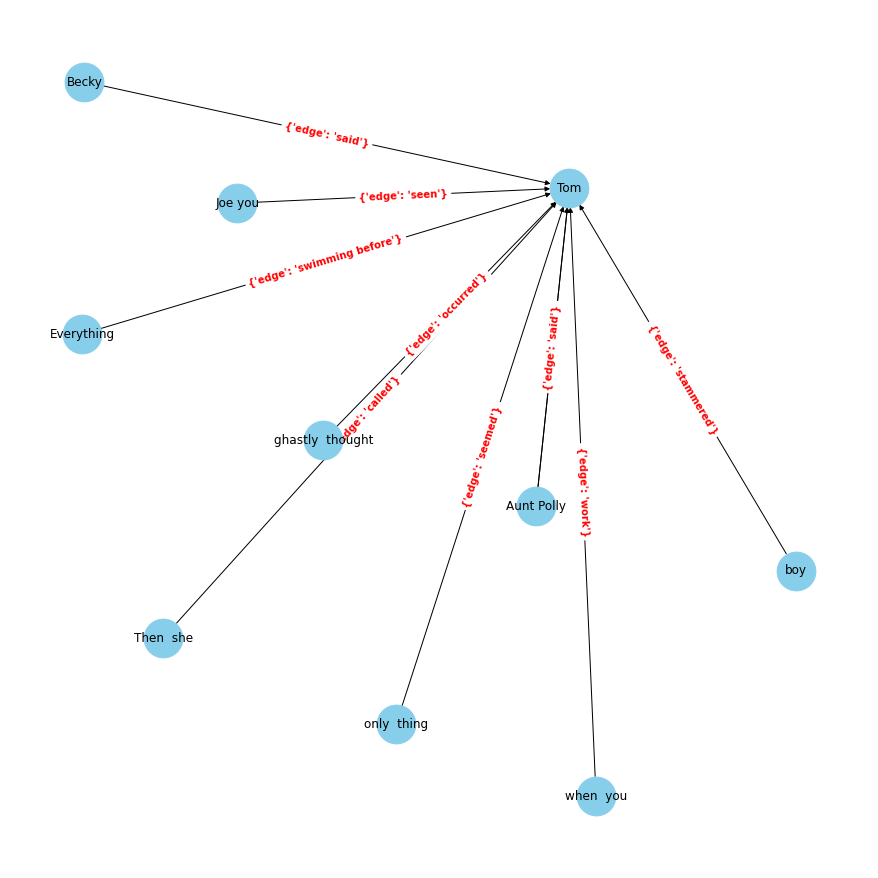

In [97]:
G=nx.from_pandas_edgelist(kg_dfs[1][kg_dfs[1]['target']=="Tom"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, pos, 
                             font_color='red', font_size=10, font_weight='bold')
plt.show()

## 2.4 Frankenstein

In [73]:
pd.Series(kg_dfs[2]['edge']).value_counts()[:25]

was         168
is           53
were         41
said         32
be           31
saw          30
are          29
found        26
had          25
passed       24
felt         21
thought      17
took         16
been         16
know         14
became       14
seemed       13
replied      13
made         12
gave         11
appeared     11
asked        10
knew         10
visited      10
feel         10
Name: edge, dtype: int64

In [74]:
pd.Series(kg_dfs[2]['source']).value_counts()[:25]

I           460
he           76
you          63
which        57
it           50
that         46
who          45
they         27
He           27
she          26
when  I      26
we           19
me           18
You          16
She          14
father       12
We           11
when  he     10
where  I      9
Clerval       8
myself        7
one           7
same  I       7
It            7
heart         6
Name: source, dtype: int64

In [75]:
pd.Series(kg_dfs[2]['target']).value_counts()[:25]

me                 127
which               34
it                  33
you                 30
him                 16
life                14
them                14
her                 13
that                10
us                   9
Elizabeth            8
myself               8
heart                8
hands                7
friends              7
day                  7
whom                 7
cottage              7
native  country      7
this                 7
peace                7
death                7
feet                 6
what                 6
own                  6
Name: target, dtype: int64

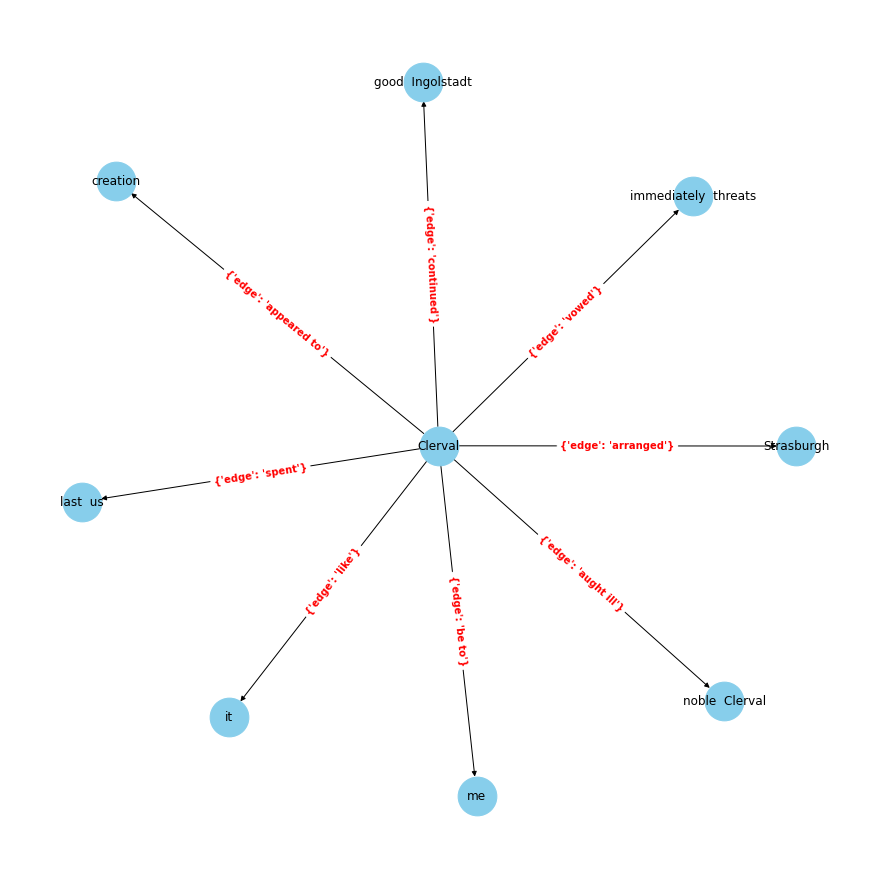

In [76]:
G=nx.from_pandas_edgelist(kg_dfs[2][kg_dfs[2]['source']=="Clerval"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, pos, 
                             font_color='red', font_size=10, font_weight='bold')
plt.show()

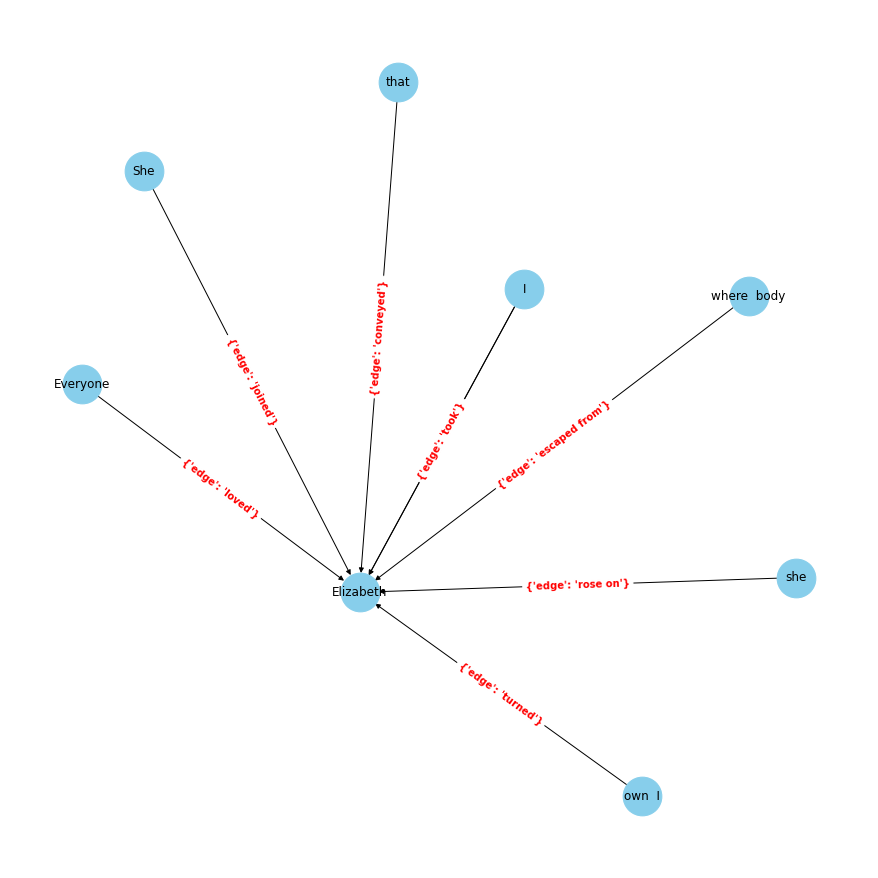

In [77]:
G=nx.from_pandas_edgelist(kg_dfs[2][kg_dfs[2]['target']=="Elizabeth"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, pos, 
                             font_color='red', font_size=10, font_weight='bold')
plt.show()

## 2.4 Jekyll and Hyde

In [78]:
pd.Series(kg_dfs[3]['edge']).value_counts()[:25]

was          79
said         66
is           26
began        12
had          12
replied      12
thought      11
were         10
seemed       10
saw          10
returned      9
been          8
set           8
have          8
added         7
took          7
came          7
asked         7
think         6
are           6
be            6
see           6
told          6
know          6
continued     5
Name: edge, dtype: int64

In [79]:
pd.Series(kg_dfs[3]['source']).value_counts()[:25]

I               88
he              56
it              39
you             38
that            16
It              14
You             11
which           10
lawyer          10
Utterson         9
He               9
Mr. Utterson     8
they             7
man              6
when  I          6
this             5
Mr. Hyde         5
we               5
who              4
Poole            4
what             4
us               3
she              3
why  he          3
yet  I           3
Name: source, dtype: int64

In [81]:
pd.Series(kg_dfs[3]['target']).value_counts()[:25]

it              31
me              23
him             20
you              9
lawyer           8
that             8
what             7
face             6
police           4
Lanyon           4
hands            4
himself          4
myself           4
end              4
door             4
What             4
Dr. Jekyll       4
life             4
man              3
key              3
reason           3
Mr. Hyde         3
Mr. Utterson     3
which            3
Henry Jekyll     2
Name: target, dtype: int64

C:\Users\Steven\AppData\Local\Temp/ipykernel_44908/1231842290.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  G=nx.from_pandas_edgelist(kg_dfs[3][kg_dfs[3]['source']=="I"][kg_dfs[3]['edge'] == "said"], "source", "target",


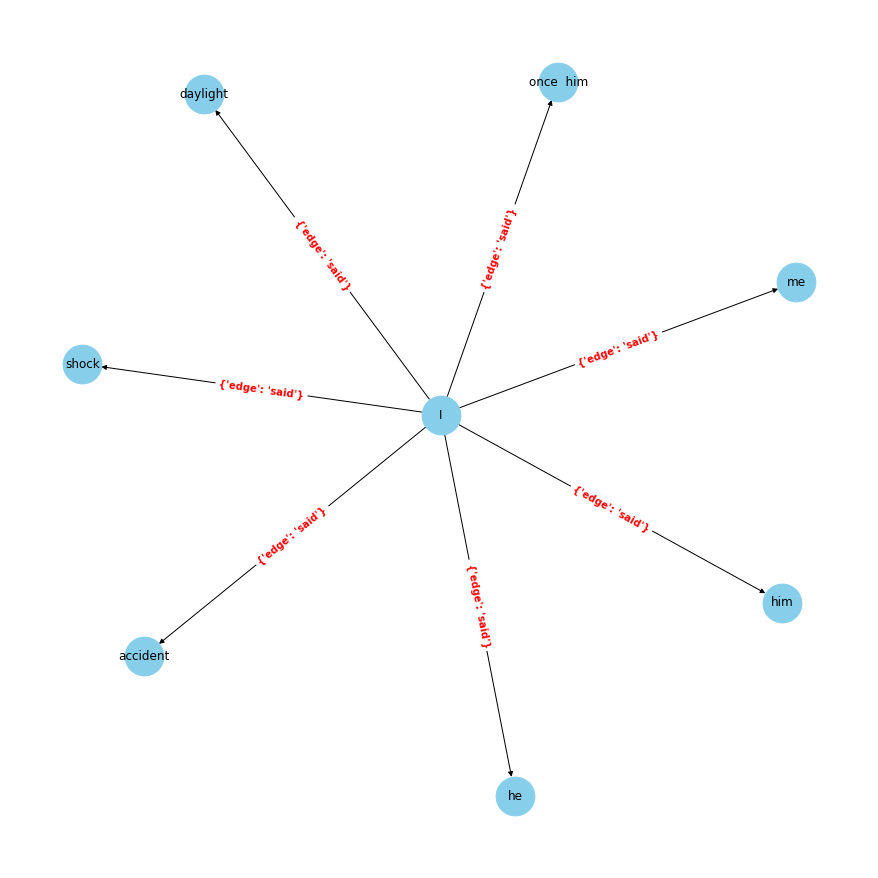

In [90]:
G=nx.from_pandas_edgelist(kg_dfs[3][kg_dfs[3]['source']=="I"][kg_dfs[3]['edge'] == "said"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, pos, 
                             font_color='red', font_size=10, font_weight='bold')
plt.show()

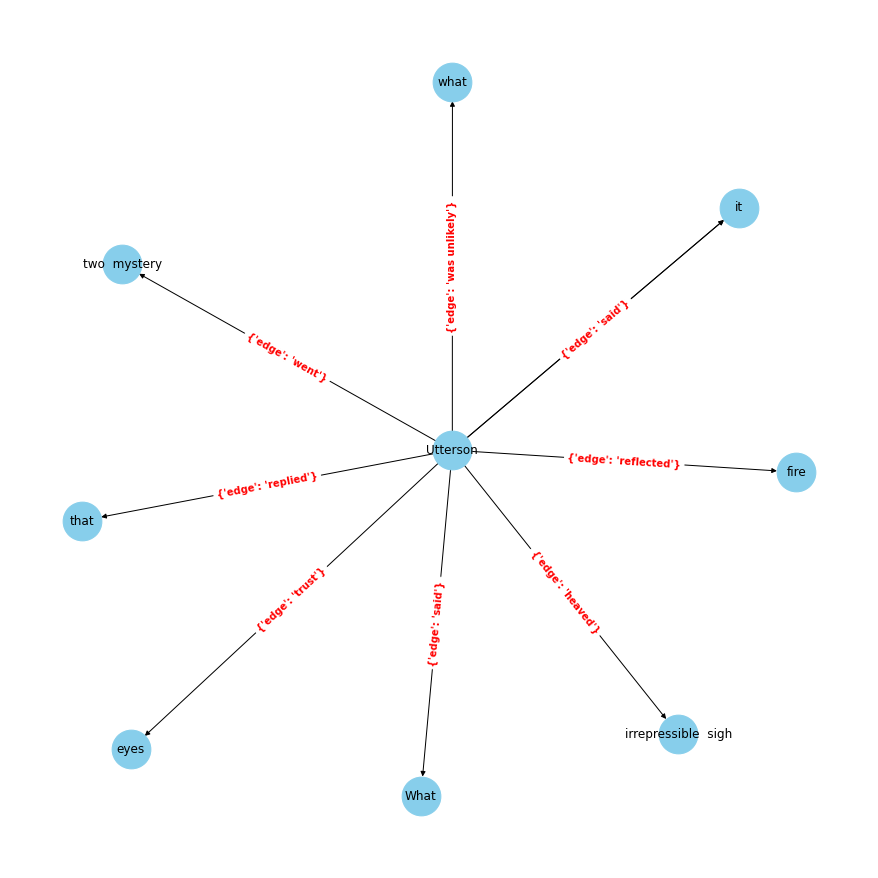

In [98]:
G=nx.from_pandas_edgelist(kg_dfs[3][kg_dfs[3]['source']=="Utterson"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
nx.draw_networkx_edge_labels(G, pos, 
                             font_color='red', font_size=10, font_weight='bold')
plt.show()